In [1]:
from utils import DataLoader  
import pandas as pd
from TimeSplit import TimeSplit

# 参数设置（请根据实际情况修改）
data_path = "/project/model_share/share_1"
fac_name = "fac20250212"
ret_name = "label1"
liquid_name = "can_trade_amt1"

In [2]:
# 初始化并加载全数据
loader = DataLoader(data_path, fac_name, ret_name, liquid_name)
loader.load_full_data()

In [3]:
# 获取指定季度的数据切片
test_quarter = "2023Q1"
factor_list = ["fac0001", "fac0002", "fac0010"]  # 用实际存在的因子名

merged_df = loader.get_dataset(factor_list, test_quarter)

In [4]:
# === 2. 提取真实可用日期列表 ===
# 注意是三者交集
fac_dates = loader.fac_df.index.get_level_values("date").unique()
ret_dates = loader.ret_df.index.unique()
liq_dates = loader.liquid_df.index.unique()
date_list = sorted(set(fac_dates) & set(ret_dates) & set(liq_dates))

In [5]:
# === 3. 调用 TimeSplit 切分时间段 ===
splitter = TimeSplit(season="2023q1", date_list=date_list)
folds, all_train_dates, test_dates = splitter.get_split(gap_days=10)

In [2]:
import json
with open("config.json") as f:
    config = json.load(f)

In [7]:
print(len(folds[0][0]), len(folds[0][1]))

347 108


In [3]:
import pynvml
pynvml.nvmlInit()
device_count = pynvml.nvmlDeviceGetCount()
free_gpu_ids = [
    i for i in range(device_count)
    if pynvml.nvmlDeviceGetMemoryInfo(
        pynvml.nvmlDeviceGetHandleByIndex(i)
    ).free / 1024 / 1024 > 8000
]
pynvml.nvmlShutdown()
print(f"Available GPU IDs: {free_gpu_ids}")

Available GPU IDs: [0, 1, 2, 3, 4, 5, 6, 7]


In [6]:
list(range(8))[::-1]

[7, 6, 5, 4, 3, 2, 1, 0]

In [1]:
for i, quarter in enumerate(["2023Q1", "2023Q2", "2023Q3", "2023Q4", "2024Q1", "2024Q2"]):
    print(i, quarter)

0 2023Q1
1 2023Q2
2 2023Q3
3 2023Q4
4 2024Q1
5 2024Q2


In [7]:
import pandas as pd
import numpy as np

# 模拟一组“预测值”和“真实收益”
df = pd.DataFrame({
    "date": np.repeat(pd.to_datetime(["2023-01-01"]), 10),
    "Code": [f"stk{i}" for i in range(10)],
    "ret": np.random.randn(10)   # 模拟真实收益
})

df['retRank'] = df.groupby('date')['ret'].rank(ascending=True)
df.sort_values(by='retRank', ascending=False, inplace=True)
df

,date,Code,ret,retRank
3,2023-01-01,stk3,1.950775,10.0
7,2023-01-01,stk7,0.777490,9.0
9,2023-01-01,stk9,-0.212740,8.0
5,2023-01-01,stk5,-0.438074,7.0
4,2023-01-01,stk4,-0.509652,6.0
0,2023-01-01,stk0,-1.048553,5.0
6,2023-01-01,stk6,-1.252795,4.0
1,2023-01-01,stk1,-1.420018,3.0
8,2023-01-01,stk8,-1.613898,2.0
2,2023-01-01,stk2,-1.706270,1.0


In [18]:
folds[1][0]

[Timestamp('2021-01-04 00:00:00'),
 Timestamp('2021-01-05 00:00:00'),
 Timestamp('2021-01-06 00:00:00'),
 Timestamp('2021-01-07 00:00:00'),
 Timestamp('2021-01-08 00:00:00'),
 Timestamp('2021-01-11 00:00:00'),
 Timestamp('2021-01-12 00:00:00'),
 Timestamp('2021-01-13 00:00:00'),
 Timestamp('2021-01-14 00:00:00'),
 Timestamp('2021-01-15 00:00:00'),
 Timestamp('2021-01-18 00:00:00'),
 Timestamp('2021-01-19 00:00:00'),
 Timestamp('2021-01-20 00:00:00'),
 Timestamp('2021-01-21 00:00:00'),
 Timestamp('2021-01-22 00:00:00'),
 Timestamp('2021-01-25 00:00:00'),
 Timestamp('2021-01-26 00:00:00'),
 Timestamp('2021-01-27 00:00:00'),
 Timestamp('2021-01-28 00:00:00'),
 Timestamp('2021-01-29 00:00:00'),
 Timestamp('2021-02-01 00:00:00'),
 Timestamp('2021-02-02 00:00:00'),
 Timestamp('2021-02-03 00:00:00'),
 Timestamp('2021-02-04 00:00:00'),
 Timestamp('2021-02-05 00:00:00'),
 Timestamp('2021-02-08 00:00:00'),
 Timestamp('2021-02-09 00:00:00'),
 Timestamp('2021-02-10 00:00:00'),
 Timestamp('2021-02-

In [ ]:


# === 4. 取出对应的数据子集（按日期切分）===
def extract_subset(df, date_list):
    idx = df.index.get_level_values("date")
    return df.loc[idx.isin(date_list)]

train_df = extract_subset(loader.fac_df, all_train_dates)
test_df = extract_subset(loader.fac_df, test_dates)
val_df_fold1 = extract_subset(loader.fac_df, folds[0][1])  # 第一折的验证集

# === 5. 打印结构验证 ===
print(f"Train Dates: {all_train_dates[0]} → {all_train_dates[-1]}, Rows: {len(train_df)}")
print(f"Test Dates: {test_dates[0]} → {test_dates[-1]}, Rows: {len(test_df)}")
print(f"Fold 1 Valid Dates: {folds[0][1][0]} → {folds[0][1][-1]}, Rows: {len(val_df_fold1)}")

In [19]:
merged_df[merged_df['date'] == pd.to_datetime('2023-03-31')]

,date,Code,fac0001,fac0002,fac0010,ret,liquid
1329703,2023-03-31,000001,0.045252,0.895918,0.489086,-0.004376,14710095.72
1329704,2023-03-31,000002,0.029462,0.861583,0.399779,-0.006497,20095920.00
1329705,2023-03-31,000006,0.016745,0.922036,0.498314,-0.000886,895104.00
1329706,2023-03-31,000007,0.275159,0.906937,0.671170,-0.003538,165240.00
1329707,2023-03-31,000008,0.007285,0.987053,0.962393,0.000213,467532.00
...,...,...,...,...,...,...,...
1332367,2023-03-31,301396,0.036458,0.934642,0.458161,0.009467,1198743.00
1332368,2023-03-31,301398,0.208054,0.553387,0.170478,0.006577,4228902.00
1332369,2023-03-31,301408,0.028979,0.902894,0.342699,0.002093,1146600.00
1332370,2023-03-31,301419,0.136164,0.780257,0.241654,0.000055,1637280.00


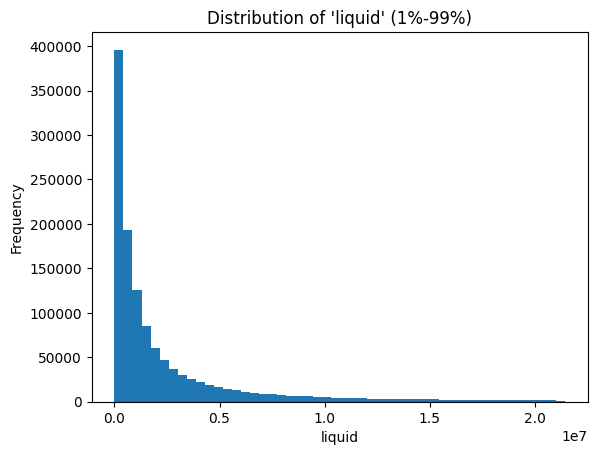

In [12]:
import matplotlib.pyplot as plt
import numpy as np
# 计算1%和99%的分位数
low, high = np.percentile(merged_df['liquid'], [3, 95])

# 筛选出1%-99%之间的数据
filtered = merged_df['liquid'][(merged_df['liquid'] >= low) & (merged_df['liquid'] <= high)]

# 绘图
plt.hist(filtered, bins=50)
plt.title("Distribution of 'liquid' (1%-99%)")
plt.xlabel("liquid")
plt.ylabel("Frequency")
plt.show()

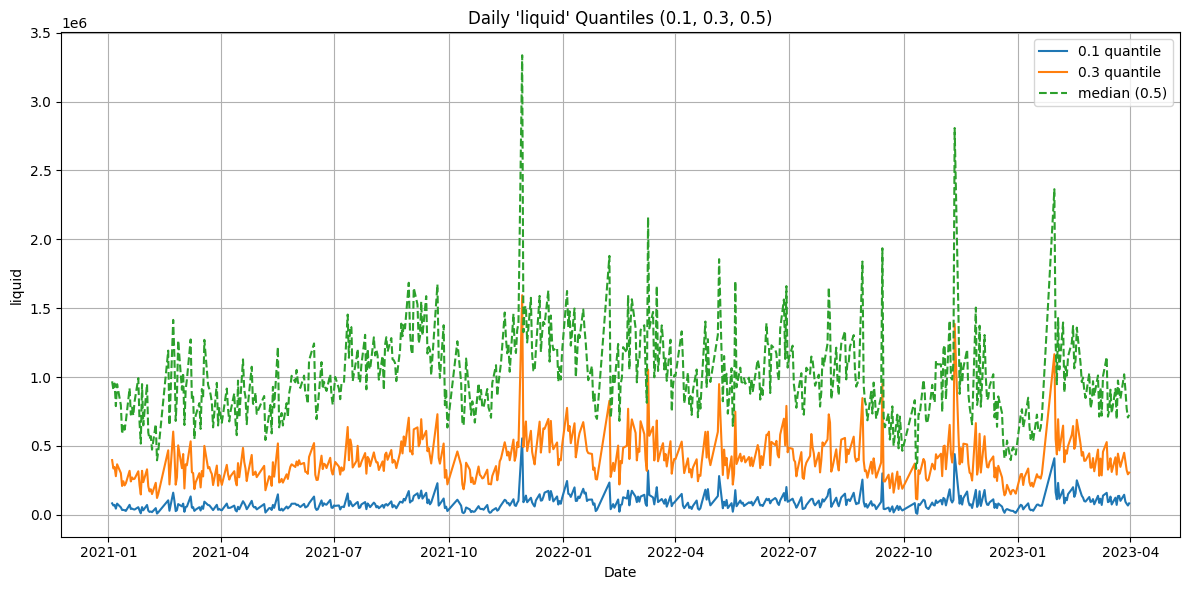

In [16]:
# 确保 date 是 datetime 类型
merged_df['date'] = pd.to_datetime(merged_df['date'])

# 按天计算多个分位数
quantiles = merged_df.groupby('date')['liquid'].quantile([0.1, 0.3, 0.5]).unstack()

# 画图
plt.figure(figsize=(12, 6))
plt.plot(quantiles.index, quantiles[0.1], label='0.1 quantile')
plt.plot(quantiles.index, quantiles[0.3], label='0.3 quantile')
plt.plot(quantiles.index, quantiles[0.5], label='median (0.5)', linestyle='--')
plt.title("Daily 'liquid' Quantiles (0.1, 0.3, 0.5)")
plt.xlabel("Date")
plt.ylabel("liquid")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [5]:
total_bytes = sum(
    getattr(loader, name).memory_usage(deep=True).sum()
    for name in ['fac_df', 'ret_df', 'liquid_df']
    if getattr(loader, name) is not None
)

print(f"Total DataLoader memory usage: {total_bytes / 1024**2:.2f} MB")


Total DataLoader memory usage: 45984.45 MB


In [1]:
import pandas as pd
import numpy as np
from BuyStrategy import BuyStrategy  # 确保 BuyStrategy.py 在同一目录下或已正确导入

# 模拟生成数据
def generate_dummy_data():
    np.random.seed(0)
    dates = pd.date_range("2023-01-01", periods=5)
    codes = [f"Stock{i:03d}" for i in range(50)]
    data = []
    for date in dates:
        for code in codes:
            data.append({
                "date": date,
                "Code": code,
                "predrank": np.random.rand(),  # 预测得分（越大越优）
                "ret": np.random.randn() * 0.01,  # 实际收益率
                "liquid": np.random.uniform(10000, 100000)  # 可买金额
            })
    return pd.DataFrame(data)

# 运行策略
df = generate_dummy_data()


In [5]:
strategy = BuyStrategy(
    df=df,
    top_pct=0.2,
    budget=1e5,
    strategy_type="liquid_equal"  # 可选 "greedy", "equal", "liquid_equal"
)
results = strategy.run()

# 输出前几天结果
print(results.head())

# 可选：保存结果
# results.to_csv("strategy_result.csv", index=False)


        date  weighted_return  position_ratio
0 2023-01-01         0.006071             1.0
1 2023-01-02        -0.000319             1.0
2 2023-01-03         0.003752             1.0
3 2023-01-04         0.000965             1.0
4 2023-01-05        -0.004518             1.0


In [1]:
import pandas as pd
from TimeSplit import TimeSplit

In [2]:
ret_data = pd.read_feather("/project/model_share/share_1/label_data/label1.fea").set_index("index")


In [3]:
ret_data

,000001,000002,000004,000005,000006,000007,000008,000009,000010,000011,...,301585,301598,603194,001391,301581,603072,301458,688758,301601,688583
index,,,,,,,,,,,,,,,,,,,,,
20210104,-0.015160,-0.008873,-0.003585,-0.010165,-0.012514,NaN,-0.003060,0.001227,-0.010241,-0.011160,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20210105,0.011209,0.005584,-0.010914,-0.010923,-0.005763,NaN,0.011299,-0.008579,0.002542,-0.002238,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20210106,0.020182,0.007172,-0.016159,-0.007238,-0.007331,-0.027498,0.003986,-0.005613,-0.003882,-0.013385,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20210107,0.002479,0.001442,-0.008702,-0.003402,-0.006117,NaN,-0.010640,-0.009734,-0.011196,-0.012402,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20210108,0.007354,0.008051,-0.006289,-0.003402,0.000611,NaN,-0.001361,-0.008165,-0.003515,0.005280,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20240624,0.008231,0.005463,-0.009059,NaN,0.014266,NaN,-0.000036,0.004655,NaN,0.001932,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20240625,0.000699,0.004620,-0.003971,NaN,0.002621,NaN,0.002039,0.003527,-0.034092,0.001526,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20240626,0.002224,-0.000587,0.029589,NaN,-0.001290,NaN,0.001879,0.001756,NaN,0.002937,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [1]:
import json

json_path = "/home/user92/model_train/SimpleFactorTiming/Select0_and_1.json"
with open(json_path, "r") as f:
    factor_dict = json.load(f)

In [5]:
for i in factor_dict:
    print(len(factor_dict[i]))

1613
1615
1343
1119
1172
1032


In [6]:
json_path = "/home/user92/model_train/SimpleFactorTiming/Select0_or_1.json"
with open(json_path, "r") as f:
    factor_dict = json.load(f)
for i in factor_dict:
    print(len(factor_dict[i]))

2503
2498
2413
2343
2377
2265


In [4]:
import subprocess
import re

def get_gpu_memory_map():
    result = subprocess.check_output(
        ['nvidia-smi', '--query-gpu=memory.free', '--format=csv,nounits,noheader']
    )
    # 转成 MB 数值
    memory_free = [int(x) for x in result.decode('utf-8').strip().split('\n')]
    return {i: mem for i, mem in enumerate(memory_free)}

gpu_map = get_gpu_memory_map()
free_gpu_ids = [i for i, mem in gpu_map.items() if mem > 20000]
print("Free GPU IDs:", free_gpu_ids)

Free GPU IDs: [0, 1, 2, 3, 4, 5, 6, 7]
